### Import the Libraries and Start the Environment

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.9 which is incompatible.


In [2]:
import matplotlib.pyplot as plt

import numpy as np
import random
import copy
import json
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### Examine the State and Action Spaces

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### Take Random Actions in the Environment

In [6]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


In [7]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, fc1_units=512, fc2_units=256):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.elu(self.fc1(state))
        x = F.elu(self.fc2(x))
        return F.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, full_state_size, full_action_size, fcs1_units=512, fc2_units=256):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of both agents states
            action_size (int): Dimension of both agents actions
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.fcs1 = nn.Linear(full_state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+full_action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, full_state, full_action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.elu(self.fcs1(full_state))
        x = torch.cat((xs, full_action), dim=1)
        x = F.elu(self.fc2(x))
        return self.fc3(x)

In [8]:
class MADDPG(object):
    '''The main class that defines and trains all the agents'''
    def __init__(self, state_size, action_size, num_agents):
        self.state_size = state_size
        self.action_size = action_size
        self.num_agents = num_agents
        self.whole_action_dim = self.action_size*self.num_agents
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE) # Replay memory
        self.maddpg_agents = [DDPG(state_size, action_size, num_agents), DDPG(state_size, action_size, num_agents)] #create agents
        self.episodes_before_training = EPISODES_BEFORE_TRAINING
        
    def reset(self):
        for agent in self.maddpg_agents:
            agent.reset()

    def step(self, i_episode, states, actions, rewards, next_states, dones):
        #for stepping maddpg
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # index 0 is for agent 0 and index 1 is for agent 1
        full_states = np.reshape(states, newshape=(-1))
        full_next_states = np.reshape(next_states, newshape=(-1))
        
        # Save experience / reward
        self.memory.add(full_states, states, actions, rewards, full_next_states, next_states, dones)
        
        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE and i_episode > self.episodes_before_training:
            for _ in range(NUM_LEARN_STEPS_PER_ENV_STEP): #learn multiple times at every step
                for agent_no in range(self.num_agents):
                    samples = self.memory.sample()
                    self.learn(samples, agent_no, GAMMA)
                self.soft_update_all()

    def soft_update_all(self):
        #soft update all the agents            
        for agent in self.maddpg_agents:
            agent.soft_update_all()
    
    def learn(self, samples, agent_no, gamma):
        #for learning MADDPG
        full_states, states, actions, rewards, full_next_states, next_states, dones = samples
        
        critic_full_next_actions = torch.zeros(states.shape[:2] + (self.action_size,), dtype=torch.float, device=DEVICE)
        for agent_id, agent in enumerate(self.maddpg_agents):
            agent_next_state = next_states[:,agent_id,:]
            critic_full_next_actions[:,agent_id,:] = agent.actor_target.forward(agent_next_state)
        critic_full_next_actions = critic_full_next_actions.view(-1, self.whole_action_dim)
        
        agent = self.maddpg_agents[agent_no]
        agent_state = states[:,agent_no,:]
        actor_full_actions = actions.clone() #create a deep copy
        actor_full_actions[:,agent_no,:] = agent.actor_local.forward(agent_state)
        actor_full_actions = actor_full_actions.view(-1, self.whole_action_dim)
                
        full_actions = actions.view(-1,self.whole_action_dim)
        
        agent_rewards = rewards[:,agent_no].view(-1,1) #gives wrong result without doing this
        agent_dones = dones[:,agent_no].view(-1,1) #gives wrong result without doing this
        experiences = (full_states, actor_full_actions, full_actions, agent_rewards, \
                       agent_dones, full_next_states, critic_full_next_actions)
        agent.learn(experiences, gamma)

    def learn_double_ddpg(self, samples, agent_no, gamma):
        #for learning double ddpg (for debug only, do not use this)
        full_states, states, actions, rewards, full_next_states, next_states, dones = samples
        temp_agent_no = np.random.randint(0,2) #to decide which agent's experience to use
        strt = temp_agent_no * self.state_size
        stp = strt + self.state_size
        full_states = full_states[:, strt:stp]
        states = states[:,temp_agent_no]
        actions = actions[:,temp_agent_no]
        rewards = rewards[:,temp_agent_no]
        full_next_states = full_next_states[:,strt:stp]
        next_states = next_states[:,temp_agent_no]
        dones = dones[:,temp_agent_no]
        agent = self.maddpg_agents[agent_no]
        critic_full_next_actions = agent.actor_target.forward(next_states)
        actor_full_actions = agent.actor_local.forward(states)
        full_actions = actions
        
        experiences = (full_states, actor_full_actions, full_actions, rewards, \
                        dones, full_next_states, critic_full_next_actions)
        
        agent.learn(experiences, gamma)
            
    def act(self, full_states, i_episode, add_noise=True):
        # all actions between -1 and 1
        actions = []
        for agent_id, agent in enumerate(self.maddpg_agents):
            action = agent.act(np.reshape(full_states[agent_id,:], newshape=(1,-1)), i_episode, add_noise)
            action = np.reshape(action, newshape=(1,-1))            
            actions.append(action)
        actions = np.concatenate(actions, axis=0)
        return actions

    def save_maddpg(self):
        for agent_id, agent in enumerate(self.maddpg_agents):
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_local_' + str(agent_id) + '.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_local_' + str(agent_id) + '.pth')

    def load_maddpg(self):
        for agent_id, agent in enumerate(self.maddpg_agents):
            #Since the model is trained on gpu, need to load all gpu tensors to cpu:
            agent.actor_local.load_state_dict(torch.load('checkpoint_actor_local_' + str(agent_id) + '.pth', map_location=lambda storage, loc: storage))
            agent.critic_local.load_state_dict(torch.load('checkpoint_critic_local_' + str(agent_id) + '.pth', map_location=lambda storage, loc: storage))
            agent.noise_scale = NOISE_END # initialize to the final epsilon value upon training


class DDPG(object):
    """Interacts with and learns from the environment.
    There are two agents and the observations of each agent has 24 dimensions. Each agent's action has 2 dimensions.
    Will use two separate actor networks (one for each agent using each agent's observations only and output that agent's action).
    The critic for each agents gets to see the actions and observations of all agents. """
    
    def __init__(self, state_size, action_size, num_agents):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state for each agent
            action_size (int): dimension of each action for each agent
        """
        self.state_size = state_size
        self.action_size = action_size        

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size).to(DEVICE)
        self.actor_target = Actor(state_size, action_size).to(DEVICE)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR, weight_decay=WEIGHT_DECAY_actor)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(num_agents*state_size, num_agents*action_size).to(DEVICE)
        self.critic_target = Critic(num_agents*state_size, num_agents*action_size).to(DEVICE)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY_critic)

        # Noise process
        self.noise = OUNoise(action_size) #single agent only
        self.noise_scale = NOISE_START
    
        # Make sure target is initialized with the same weight as the source (makes a big difference)
        self.hard_update(self.actor_target, self.actor_local)
        self.hard_update(self.critic_target, self.critic_local)

    def act(self, states, i_episode, add_noise=True):
        """Returns actions for given state as per current policy."""
        
        if i_episode > EPISODES_BEFORE_TRAINING and self.noise_scale > NOISE_END:
            #self.noise_scale *= NOISE_REDUCTION
            self.noise_scale = NOISE_REDUCTION**(i_episode-EPISODES_BEFORE_TRAINING)
        #else keep the previous value
        
        if not add_noise:
            self.noise_scale = 0.0
                                    
        states = torch.from_numpy(states).float().to(DEVICE)
        self.actor_local.eval()
        with torch.no_grad():
            actions = self.actor_local(states).cpu().data.numpy()
        self.actor_local.train()
        
        #add noise
        actions += self.noise_scale*self.add_noise2() #works much better than OU Noise process
        #actions += self.noise_scale*self.noise.sample()
        
        return np.clip(actions, -1, 1)

    def add_noise2(self):
        noise = 0.5*np.random.randn(1,self.action_size) #sigma of 0.5 as sigma of 1 will have alot of actions just clipped
        return noise
        
    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        #for MADDPG
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        full_states, actor_full_actions, full_actions, agent_rewards, agent_dones, full_next_states, critic_full_next_actions = experiences
        # ---------------------------- update critic ---------------------------- #
        # Get Q values from target models
        Q_target_next = self.critic_target(full_next_states, critic_full_next_actions)
        # Compute Q targets for current states (y_i)
        Q_target = agent_rewards + gamma * Q_target_next * (1 - agent_dones)
        # Compute critic loss
        Q_expected = self.critic_local(full_states, full_actions)
        critic_loss = F.mse_loss(input=Q_expected, target=Q_target) #target=Q_targets.detach() #not necessary to detach
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        #torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1.0) #clip the gradient for the critic network (Udacity hint)
        self.critic_optimizer.step()
        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actor_loss = -self.critic_local.forward(full_states, actor_full_actions).mean() #-ve b'cse we want to do gradient ascent
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()                  

    def soft_update_all(self):
        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)
   
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

    def hard_update(self, target, source):
        for target_param, source_param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(source_param.data)


class OUNoise(object):
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.size = size
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        #dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

class ReplayBuffer(object):
    """Fixed-size buffer to store experience tuples."""
#actions += self.noise.sample()
    def __init__(self, buffer_size, batch_size):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["full_state", "state", "action", "reward", \
                                                                "full_next_state", "next_state", "done"])

    def add(self, full_state, state, action, reward, full_next_state, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(full_state, state, action, reward, full_next_state, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        full_states = torch.from_numpy(np.array([e.full_state for e in experiences if e is not None])).float().to(DEVICE)
        states = torch.from_numpy(np.array([e.state for e in experiences if e is not None])).float().to(DEVICE)
        actions = torch.from_numpy(np.array([e.action for e in experiences if e is not None])).float().to(DEVICE)
        rewards = torch.from_numpy(np.array([e.reward for e in experiences if e is not None])).float().to(DEVICE)
        full_next_states = torch.from_numpy(np.array([e.full_next_state for e in experiences if e is not None])).float().to(DEVICE)
        next_states = torch.from_numpy(np.array([e.next_state for e in experiences if e is not None])).float().to(DEVICE)
        dones = torch.from_numpy(np.array([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(DEVICE)

        return (full_states, states, actions, rewards, full_next_states, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [9]:
#Constants
BUFFER_SIZE = int(5e5)                # replay buffer size
BATCH_SIZE = 512                      # minibatch size
GAMMA = 0.99                          # discount factor
TAU = 2e-3                            # for soft update of target parameters
LR_ACTOR = 1e-4           
LR_CRITIC = 1e-4        
WEIGHT_DECAY_actor = 1e-7 
WEIGHT_DECAY_critic = 1e-7
EPISODES_BEFORE_TRAINING = 330
#to decay exploration as it learns
NOISE_START = 1.0
NOISE_END = 0.13
NOISE_REDUCTION = 0.999
NUM_LEARN_STEPS_PER_ENV_STEP = 5
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

state_size=env_info.vector_observations.shape[1]
action_size=brain.vector_action_space_size
num_agents=env_info.vector_observations.shape[0]
MADDPGo = MADDPG(state_size=state_size, action_size=action_size, num_agents=num_agents)

def train(n_episodes=5000, t_max=1200):
    avg_scores_list = []
    scores_deque = deque(maxlen=100)
    scores_list = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]     
        states = env_info.vector_observations                   
        MADDPGo.reset() 
        scores = np.zeros(num_agents)                          
        num_steps = 0
        for _ in range(t_max):
            actions = MADDPGo.act(states, i_episode)
            env_info = env.step(actions)[brain_name]           
            next_states = env_info.vector_observations         
            rewards = env_info.rewards                         
            dones = env_info.local_done                        
            scores += rewards                                  
            MADDPGo.step(i_episode, states, actions, rewards, next_states, dones)          
            states = next_states                               
            num_steps += 1
            if np.any(dones):                                  
                break
            # print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))
        
        scores_deque.append(np.max(scores))
        scores_list.append(np.max(scores))
        avg_scores_list.append(np.mean(scores_deque))
        
        #print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {}'.format(i_episode, np.mean(scores_deque), score), end="")
        print('Episode {}\tAverage Score: {:.2f}\tCurrent Score: {}'.format(i_episode, np.mean(scores_deque), np.max(scores)))
        print('Noise Scaling: {}, Memory size: {} and Num Steps: {}'.format(MADDPGo.maddpg_agents[0].noise_scale, len(MADDPGo.memory), num_steps))
        
        if i_episode % 300 == 0:
            MADDPGo.save_maddpg()
            print('Saved Model: Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            
        if np.mean(scores_deque) > 0.5 and len(scores_deque) >= 100:
            MADDPGo.save_maddpg()
            print('Saved Model: Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            break
            
    return scores_list, avg_scores_list

In [10]:
scores, scores_avg = train()

Episode 1	Average Score: 0.10	Current Score: 0.10000000149011612
Noise Scaling: 1.0, Memory size: 33 and Num Steps: 33
Episode 2	Average Score: 0.05	Current Score: 0.0
Noise Scaling: 1.0, Memory size: 47 and Num Steps: 14
Episode 3	Average Score: 0.03	Current Score: 0.0
Noise Scaling: 1.0, Memory size: 61 and Num Steps: 14
Episode 4	Average Score: 0.03	Current Score: 0.0
Noise Scaling: 1.0, Memory size: 75 and Num Steps: 14
Episode 5	Average Score: 0.06	Current Score: 0.20000000298023224
Noise Scaling: 1.0, Memory size: 146 and Num Steps: 71
Episode 6	Average Score: 0.05	Current Score: 0.0
Noise Scaling: 1.0, Memory size: 160 and Num Steps: 14
Episode 7	Average Score: 0.04	Current Score: 0.0
Noise Scaling: 1.0, Memory size: 174 and Num Steps: 14
Episode 8	Average Score: 0.04	Current Score: 0.0
Noise Scaling: 1.0, Memory size: 189 and Num Steps: 15
Episode 9	Average Score: 0.03	Current Score: 0.0
Noise Scaling: 1.0, Memory size: 203 and Num Steps: 14
Episode 10	Average Score: 0.03	Curre

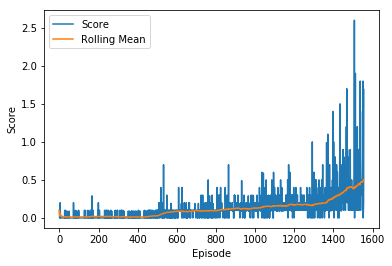

In [11]:
plt.plot(scores, label="Score")
plt.plot(scores_avg, label="Rolling Mean")
plt.xlabel("Episode")
plt.ylabel("Score")
plt.legend()
plt.savefig('report.png')
plt.show()

In [12]:
env.close()